## PCA Implementation using CVXPY

- Find the projection matrix P that minimizes reconstruction error
- Equivalently: maximize the variance captured by the principal components

The optimization formulation:
    minimize ||X - X @ P @ P.T||_F^2
    subject to: P.T @ P = I (orthonormality)

For a single principal component, this becomes:
    maximize v.T @ (X.T @ X) @ v
    subject to: ||v||_2 = 1

I use a SDP approach where we optimize over V = v @ v.T, with constraints that V is positive semidefinite and rank-1.


Features (13): ['4-MP', '2-OH-4MP', 'Leucine', '2-OH-3MP', 'alloisoleucine', 'isoleucine', '4-OH-PAA', '4-OH-PPA', 'tyrosine', 'cholenoic acid', 'cholenoic acid blanked', 'Cholic acid', 'Cholic acid blanked']
Original shape: (99, 13)
Shape after dropping NA: (96, 13)

Data matrix shape: (96, 13)
  n_samples = 96
  n_features = 13

Covariance matrix shape: (13, 13)
COMPUTING PCA VIA CVXPY (SDP Relaxation)

PC 1 computation.
- Eigenvalue (variance): 3.3718

PC 2 computation.
- Eigenvalue (variance): 2.3094

PC 3 computation.
- Eigenvalue (variance): 2.0147
COMPUTING STANDARD PCA (Eigendecomposition)
COMPARISON OF RESULTS

Eigenvalues (Variance explained by each PC):
PC    CVX             Standard        Diff      
PC1   3.3718          3.3718          0.000024  
PC2   2.3094          2.3094          0.000006  
PC3   2.0147          2.0147          0.000007  

Variance explained ratio (CVX):
  PC1: 25.67%
  PC2: 17.58%
  PC3: 15.34%

Total variance explained by 3 components: 58.58%
Proje

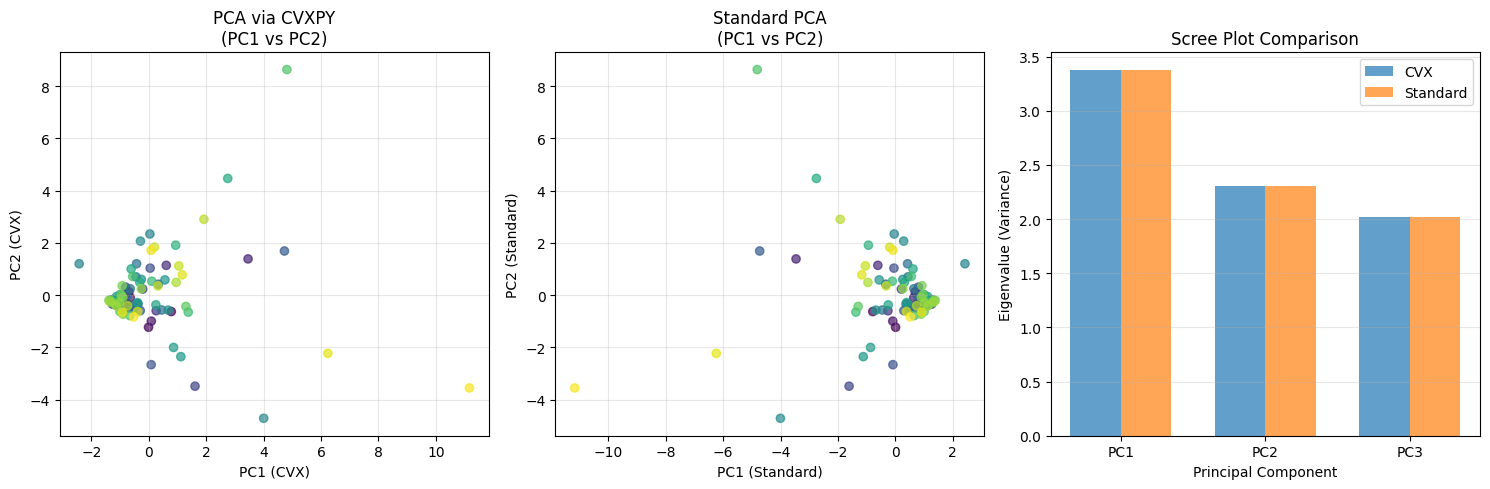

In [1]:

import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt
from numpy.linalg import eigh

df = pd.read_csv('data/stickland.csv')

feature_cols = df.columns[2:]
print(f"\nFeatures ({len(feature_cols)}): {list(feature_cols)}")

# get numeric data and handle NA values
X = df[feature_cols].apply(pd.to_numeric, errors='coerce')
print(f"Original shape: {X.shape}")
X = X.dropna()
print(f"Shape after dropping NA: {X.shape}")

X_np = X.values.astype(float)

# Center the data (subtract mean) and standardizw
X_mean = X_np.mean(axis=0)
X_centered = X_np - X_mean
X_std = X_centered.std(axis=0)
X_std[X_std == 0] = 1  
X_standardized = X_centered / X_std

print(f"\nData matrix shape: {X_standardized.shape}")
print(f"  n_samples = {X_standardized.shape[0]}")
print(f"  n_features = {X_standardized.shape[1]}")

# covariance matrix
n_samples, n_features = X_standardized.shape
C = (X_standardized.T @ X_standardized) / (n_samples - 1)
print(f"\nCovariance matrix shape: {C.shape}")

#find a single principal component using CVXPY (using SDP relaxation)
def pca_cvx_single_component(C, n_features):
    V = cp.Variable((n_features, n_features), symmetric=True)
    
    constraints = [
        V >> 0,           # positive semidefinite
        cp.trace(V) == 1  # normalized
    ]
    
    objective = cp.Maximize(cp.trace(C @ V))
    problem = cp.Problem(objective, constraints)
    
    problem.solve(solver=cp.SCS, verbose=False)
    
    return V.value, problem.value

# multiple pcs using deflation (after finding each PC, deflate the covariance matrix by removing the variance)
def pca_cvx_deflation(X, n_components=3):
    n_samples, n_features = X.shape
    C = (X.T @ X) / (n_samples - 1)
    
    components = []
    eigenvalues = []
    C_current = C.copy()
    
    for k in range(n_components):
        print(f"\nPC {k+1} computation.")
        
        V_opt, obj_val = pca_cvx_single_component(C_current, n_features)
        
        # Extract principal component from V via eigendecomposition
        # The leading eigenvector of V gives the PC direction
        eigvals, eigvecs = eigh(V_opt)
        idx = np.argmax(eigvals)
        v = eigvecs[:, idx]
        
        if v[np.argmax(np.abs(v))] < 0:
            v = -v
        
        components.append(v)
        eigenvalues.append(obj_val)
        
        # deflate: remove variance explained by this component
        C_current = C_current - obj_val * np.outer(v, v)
        
        print(f"- Eigenvalue (variance): {obj_val:.4f}")
    
    return np.array(components).T, np.array(eigenvalues)

#standard PCA using eigendecomposition for comparison.
def pca_standard(X, n_components=3):
    n_samples, n_features = X.shape
    C = (X.T @ X) / (n_samples - 1)
    
    eigvals, eigvecs = eigh(C)
    
    # sort by eigenvalue (descending)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]
    
    return eigvecs[:, :n_components], eigvals[:n_components]


# run both methods
print("COMPUTING PCA VIA CVXPY (SDP Relaxation)")

n_components = 3
components_cvx, eigenvalues_cvx = pca_cvx_deflation(X_standardized, n_components)

print("COMPUTING STANDARD PCA (Eigendecomposition)")

components_std, eigenvalues_std = pca_standard(X_standardized, n_components)

# Compare results
print("COMPARISON OF RESULTS")

print("\nEigenvalues (Variance explained by each PC):")
print(f"{'PC':<5} {'CVX':<15} {'Standard':<15} {'Diff':<10}")
for i in range(n_components):
    diff = abs(eigenvalues_cvx[i] - eigenvalues_std[i])
    print(f"PC{i+1:<3} {eigenvalues_cvx[i]:<15.4f} {eigenvalues_std[i]:<15.4f} {diff:<10.6f}")

total_var = np.sum(eigenvalues_std[:len(eigenvalues_std)])
print(f"\nVariance explained ratio (CVX):")
for i in range(n_components):
    ratio = eigenvalues_cvx[i] / np.trace(C) * 100
    print(f"  PC{i+1}: {ratio:.2f}%")

print(f"\nTotal variance explained by {n_components} components: {sum(eigenvalues_cvx)/np.trace(C)*100:.2f}%")

# project data onto principal components
print("Project data")

Z_cvx = X_standardized @ components_cvx
Z_std = X_standardized @ components_std

print(f"\nProjected data shape: {Z_cvx.shape}")
print(f"- (n_samples x n_components)")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# CVX PCA projection (PC1 vs PC2)
ax1 = axes[0]
scatter1 = ax1.scatter(Z_cvx[:, 0], Z_cvx[:, 1], c=range(len(Z_cvx)), cmap='viridis', alpha=0.7)
ax1.set_xlabel('PC1 (CVX)')
ax1.set_ylabel('PC2 (CVX)')
ax1.set_title('PCA via CVXPY\n(PC1 vs PC2)')
ax1.grid(True, alpha=0.3)

# Standard PCA projection (PC1 vs PC2)
ax2 = axes[1]
scatter2 = ax2.scatter(Z_std[:, 0], Z_std[:, 1], c=range(len(Z_std)), cmap='viridis', alpha=0.7)
ax2.set_xlabel('PC1 (Standard)')
ax2.set_ylabel('PC2 (Standard)')
ax2.set_title('Standard PCA\n(PC1 vs PC2)')
ax2.grid(True, alpha=0.3)

# Scree plot (variance explained)
ax3 = axes[2]
x_pos = np.arange(1, n_components + 1)
width = 0.35
ax3.bar(x_pos - width/2, eigenvalues_cvx, width, label='CVX', alpha=0.7)
ax3.bar(x_pos + width/2, eigenvalues_std, width, label='Standard', alpha=0.7)
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Eigenvalue (Variance)')
ax3.set_title('Scree Plot Comparison')
ax3.set_xticks(x_pos)
ax3.set_xticklabels([f'PC{i}' for i in x_pos])
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('pca_cvx_results.png', dpi=150, bbox_inches='tight')
print("\nVisualization saved to: pca_cvx_results.png")

results_df = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(n_components)],
    'Eigenvalue_CVX': eigenvalues_cvx,
    'Eigenvalue_Std': eigenvalues_std,
    'Variance_Explained_Pct': eigenvalues_cvx / np.trace(C) * 100
})
results_df.to_csv('pca_results.csv', index=False)

loadings_df = pd.DataFrame(
    components_cvx,
    index=feature_cols,
    columns=[f'PC{i+1}' for i in range(n_components)]
)
loadings_df.to_csv('pca_loadings.csv')

print("PCA LOADINGS (Feature contributions to each PC)")
print("\nTop 3 contributing features for each PC:")
for i in range(n_components):
    pc_loadings = np.abs(components_cvx[:, i])
    top_idx = np.argsort(pc_loadings)[::-1][:3]
    print(f"\nPC{i+1}:")
    for idx in top_idx:
        print(f"{feature_cols[idx]}: {components_cvx[idx, i]:.4f}")